### Matthew Collins
#### DSC680: Project 2
#### Sentiment Analysis of Financial Markets

In [247]:
# Import libraries

import re
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import collections
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, precision_score,recall_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
import nltk

from lightgbm import LGBMClassifier

import string
from textblob import TextBlob




In [214]:
# Import the dataset

df = pd.read_csv('all-data.csv', encoding = 'ISO-8859-1')
df.head()


,rating,news_headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating         4846 non-null   object
 1   news_headline  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


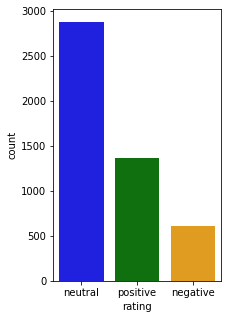

In [12]:
# Count the frequencies of each sentiment/rating

plt.figure(figsize = (3,5))
sns.countplot(df['rating'], order = df.rating.value_counts().index, palette = ('blue', 'green', 'orange'))
plt.show()

#### Explore the data
Create a wordcloud to understand the top words in the European financial news

In [85]:
# Check for missing values

df.isnull().sum()

rating           0
news_headline    0
dtype: int64

In [87]:
# Check the dataset shape

df.shape

(4846, 2)

In [200]:
# Convert the words to lower case and combine them into a variable

headlines = ''.join(df['news_headline'].str.lower())

In [244]:
# Setup the stopwords and create wordcloud variable

stopwords = STOPWORDS

stopwords.add('will')
stopwords.add('company')
stopwords.add('said')
stopwords.add('s')
stopwords.add('(')
stopwords.add(')')
stopwords.add("%")
stopwords.add("'s")
stopwords.add(':')
stopwords.add(',')
stopwords.add('.the')

wordcloud = WordCloud(stopwords = stopwords, background_color = 'white', max_words = 1000).generate(headlines)

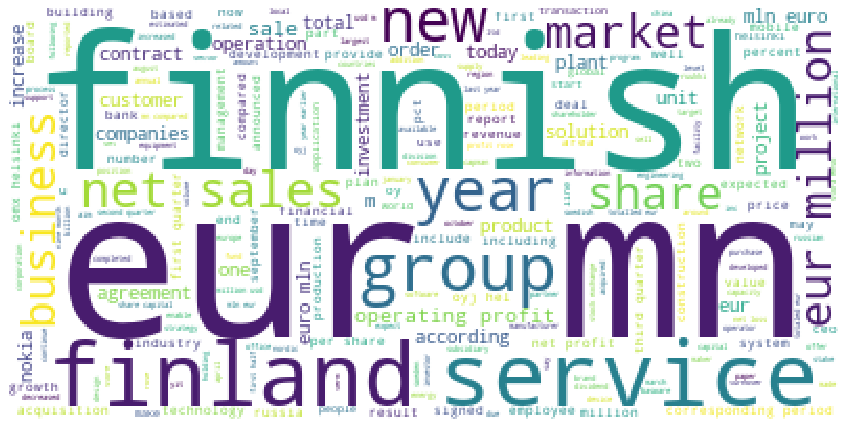

In [78]:
# Plot and view the wordcloud

rcParams['figure.figsize'] = 15, 15
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [245]:
# Evaluate the word occurence using a Pareto analysis

filtered_words = [word for word in headlines.split() if word not in stopwords]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

<BarContainer object of 10 artists>

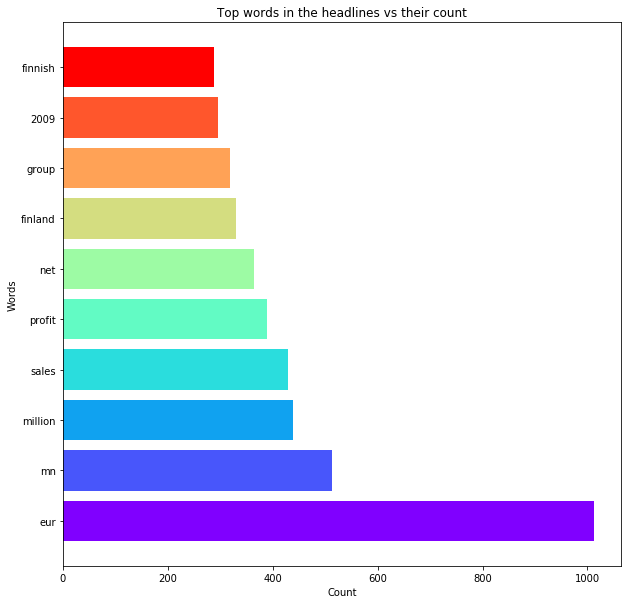

In [246]:
# Plot the Pareto of words

colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 10, 10

plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

#### Data Preprocessing for Sentiment Analysis

In [212]:
# Remove punctuation

english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['news_headline'] = df['news_headline'].apply(lambda x: cleaning_punctuations(x))

df.head()


,rating,news_headline
0,neutral,According to Gran the company has no plans to...
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company s updated strategy fo...


In [213]:
# Remove repeating characters

def cleaning_repeats(text):
    return re.sub(r'(.)1+', r'1', text)

df['news_headline'] = df['news_headline'].apply(lambda x: cleaning_repeats(x))

df.head()

,rating,news_headline
0,neutral,According to Gran the company has no plans to...
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company s updated strategy fo...


In [111]:
# Use text blob to measure sentiment 

df['polarity'] = df['news_headline'].map(lambda text: TextBlob(text).sentiment.polarity)
df['news_len'] = df['news_headline'].astype(str).apply(len)
df['word_count'] = df['news_headline'].apply(lambda x: len(str(x).split()))

df.head()

,rating,news_headline,polarity,news_len,word_count
0,neutral,According to Gran the company has no plans to...,0.000000,124,22
1,neutral,Technopolis plans to develop in stages an area...,0.083333,186,28
2,negative,The international electronic industry company ...,0.000000,225,33
3,positive,With the new production plant the company woul...,-0.064802,205,32
4,positive,According to the company s updated strategy fo...,0.000000,190,34


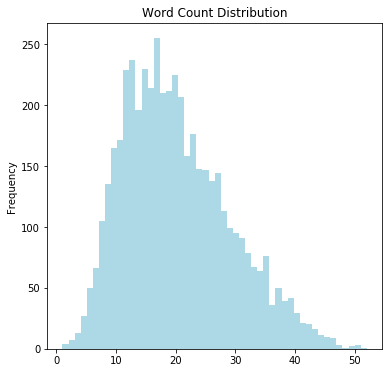

In [118]:
# Analysis of word_count

df.word_count.plot(kind = 'hist', bins = 50, color = 'lightblue', figsize = (6, 6), title = 'Word Count Distribution')


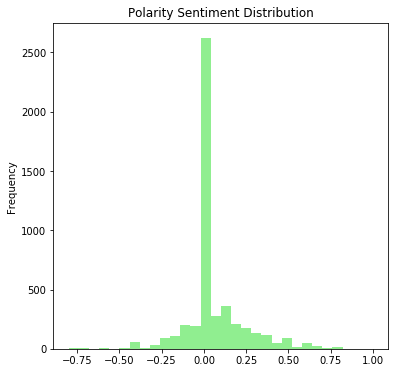

In [120]:
# Analysis of Polarity distribution

df.polarity.plot(kind = 'hist', bins = 30, color = 'lightgreen', figsize = (6,6), title = 'Polarity Sentiment Distribution')

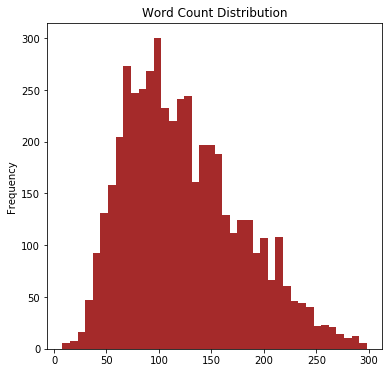

In [129]:
# Analysis of news word length

df.news_len.plot(kind = 'hist', bins = 40, color = 'brown', figsize = (6,6), title = 'Word Count Distribution')

#### Preprocess data for supervised learning (start with fresh df)

In [215]:
# Start with a fresh df

df.head()

,rating,news_headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [216]:
# Numerically encode

features = df.iloc[:,1].values
labels = df.iloc[:,0].values


In [223]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [225]:
# Convert text to numerics

vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()


In [226]:
# Split the data into test and training

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

### Choosing the appropriate ML algorithm

#### 1. Random Forest Model

In [162]:
# Create model (start with random forest because of its ability to act upon non-normalized data)

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [163]:
# Make predictions

predictions = text_classifier.predict(X_test)

In [165]:
# Evaluate Model Performance

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))


[[ 45  59  24]
 [  6 540  29]
 [  8 128 131]]
              precision    recall  f1-score   support

    negative       0.76      0.35      0.48       128
     neutral       0.74      0.94      0.83       575
    positive       0.71      0.49      0.58       267

    accuracy                           0.74       970
   macro avg       0.74      0.59      0.63       970
weighted avg       0.74      0.74      0.72       970

0.7381443298969073


#### 2. K-Nearest Neighbor model

In [187]:
text_classifier = KNeighborsClassifier(n_neighbors=200)
text_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=200, p=2,
                     weights='uniform')

In [188]:
predictions = text_classifier.predict(X_test)

In [189]:
# Evaluate Model Performance

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))


[[ 11  86  31]
 [  0 561  14]
 [  2 189  76]]
              precision    recall  f1-score   support

    negative       0.85      0.09      0.16       128
     neutral       0.67      0.98      0.80       575
    positive       0.63      0.28      0.39       267

    accuracy                           0.67       970
   macro avg       0.72      0.45      0.45       970
weighted avg       0.68      0.67      0.60       970

0.668041237113402


#### 3. Logistic Regression Model

In [190]:
text_classifier = LogisticRegression()
text_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [191]:
predictions = text_classifier.predict(X_test)

In [192]:
# Evaluate Model Performance

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))


[[ 45  66  17]
 [  4 544  27]
 [ 13 121 133]]
              precision    recall  f1-score   support

    negative       0.73      0.35      0.47       128
     neutral       0.74      0.95      0.83       575
    positive       0.75      0.50      0.60       267

    accuracy                           0.74       970
   macro avg       0.74      0.60      0.64       970
weighted avg       0.74      0.74      0.72       970

0.7443298969072165


#### LGBM Model

In [195]:
text_classifier = LGBMClassifier(n_jobs = 1)
text_classifier.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [196]:
predictions = text_classifier.predict(X_test)

In [248]:
# Evaluate Model Performance

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[ 58  54  16]
 [ 12 525  38]
 [ 15 116 136]]
              precision    recall  f1-score   support

    negative       0.68      0.45      0.54       128
     neutral       0.76      0.91      0.83       575
    positive       0.72      0.51      0.60       267

    accuracy                           0.74       970
   macro avg       0.72      0.63      0.66       970
weighted avg       0.73      0.74      0.73       970

0.7412371134020619


In [253]:
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label = 'your_label')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'blue', lw =1, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.legend(loc = 'lower right')
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Prediction Using Word Dictionary Method

In [204]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

df['news_headline']= df['news_headline'].apply(lambda x: stemming_on_text(x))
df['news_headline'].head()

0    According to Gran  the company has no plans to...
1    Technopolis plans to develop in stages an area...
2    The international electronic industry company ...
3    With the new production plant the company woul...
4    According to the company s updated strategy fo...
Name: news_headline, dtype: object

In [207]:
# Separate the input feature and the label

X = df['news_headline']
y = df['rating']

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [262]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  58525


In [263]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [267]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [270]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

y_pred1 = LR.predict(X_test)

In [272]:


fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label = 'your_label')

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'blue', lw =1, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.legend(loc = 'lower right')
plt.show()

ValueError: multiclass format is not supported